<a href="https://colab.research.google.com/github/PosgradoMNA/actividades-de-aprendizaje-RobVegaTec/blob/main/Actividad7_ejercicio_3_TecMty_kmeans_target_A01378921.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

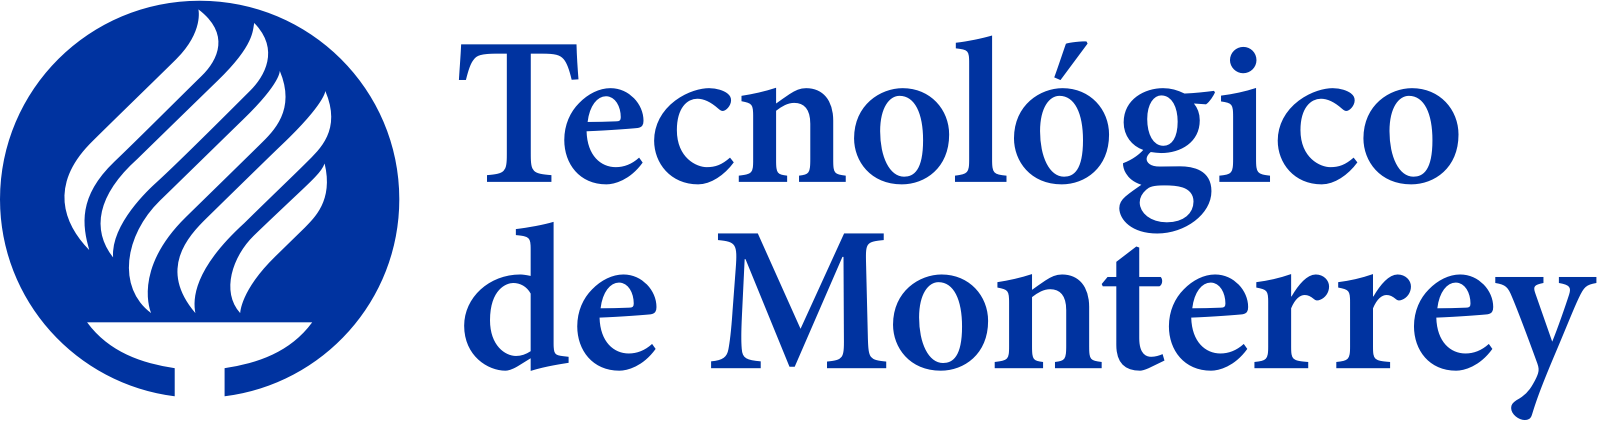

Materia: Ciencia y analítica de datos

Nombre de la actividad: Semana 8: Actividad Semanal 7 Regresiones y K means

Nombre del alumno: Roberto Vega Alanis

Matrícula: A01378921

Nombre de la profesora: Dra. María de la Paz Rico Fernández

Fecha: 05 de Noviembre de 2022

Este notebook se basa en información de target
![imagen.png](https://www.america-retail.com/static//2020/12/target01.jpg)


Ahora imagina que somos parte del equipo de data science de la empresa Target, una de las tiendas con mayor presencia en Estados Unidos. El departamento de logistica acude a nosotros para saber donde le conviene poner sus almacenes, para que se optimice el gasto de gasolina, los tiempos de entrega de los productos y se disminuyan costos. Para ello, nos pasan los datos de latitud y longitud de cada una de las tiendas.

https://www.kaggle.com/datasets/saejinmahlauheinert/target-store-locations?select=target-locations.csv

Si quieres saber un poco más de graficas geográficas consulta el siguiente notebook
https://colab.research.google.com/github/QuantEcon/quantecon-notebooks-datascience/blob/master/applications/maps.ipynb#scrollTo=uo2oPtSCeAOz

In [50]:
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [51]:
import pandas as pd
import numpy as np
from tqdm import tqdm
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import geopandas

Importa la base de datos

In [52]:
url="https://raw.githubusercontent.com/marypazrf/bdd/main/target-locations.csv"
df=pd.read_csv(url)

Exploremos los datos.

In [53]:

df.head()


,name,latitude,longitude,address,phone,website
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1839 non-null   object 
 1   latitude   1839 non-null   float64
 2   longitude  1839 non-null   float64
 3   address    1839 non-null   object 
 4   phone      1839 non-null   object 
 5   website    1839 non-null   object 
dtypes: float64(2), object(4)
memory usage: 86.3+ KB


**Definición de Latitud y Longitud**

**Latitud** Es la distancia en grados, minutos y segundos que hay con respecto al paralelo principal, que es el ecuador (0º). La latitud puede ser norte y sur.

**Longitud**: Es la distancia en grados, minutos y segundos que hay con respecto al meridiano principal, que es el meridiano de Greenwich (0º).La longitud puede ser este y oeste.

In [55]:
latlong=df[["latitude","longitude"]]

¡Visualizemos los datos!, para empezar a notar algún patron. 

A simple vista pudieramos pensar que tenemos algunos datos atípicos u outliers, pero .... no es así, simplemente esta grafica no nos está dando toda la información.

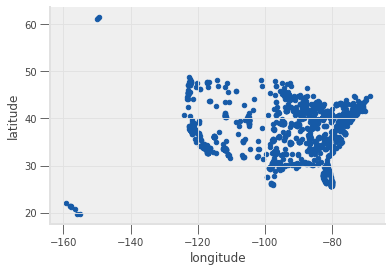

In [56]:
#extrae los datos interesantes
latlong.plot.scatter( "longitude","latitude")

In [57]:
latlong.describe()

,latitude,longitude
count,1839.000000,1839.000000
mean,37.791238,-91.986881
std,5.272299,16.108046
min,19.647855,-159.376962
25%,33.882605,-98.268828
50%,38.955432,-87.746346
75%,41.658341,-80.084833
max,61.577919,-68.742331


Para entender un poco más, nos auxiliaremos de una librería para graficar datos geográficos. Esto nos ayudara a tener un mejor entendimiento de ellos.




In [58]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from shapely.geometry import Point

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

In [59]:
df["Coordinates"] = list(zip(df.longitude, df.latitude))
df["Coordinates"] = df["Coordinates"].apply(Point)
df.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417369999999 33.2242254)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98977789999999 33.3345501)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593169999999 30.6028747)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.9715595 34.5601477)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.4464222 31.2660613)


In [60]:
gdf = gpd.GeoDataFrame(df, geometry="Coordinates")
gdf.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.44642 31.26606)


In [61]:
#mapa

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

world.head()

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,920938,Oceania,Fiji,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,53950935,Africa,Tanzania,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253,Africa,W. Sahara,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,35623680,North America,Canada,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,326625791,North America,United States of America,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [62]:
#graficar el mapa
world.name.unique()

array(['Fiji', 'Tanzania', 'W. Sahara', 'Canada',
       'United States of America', 'Kazakhstan', 'Uzbekistan',
       'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile',
       'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti',
       'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway',
       'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste',
       'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil',
       'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua',
       'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela',
       'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico',
       'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal',
       'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon',
       'Togo', 'Ghana', "Côte d'Ivoire", 'Guinea', 'Guinea-Bissau',
       'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.',
       'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', 'M

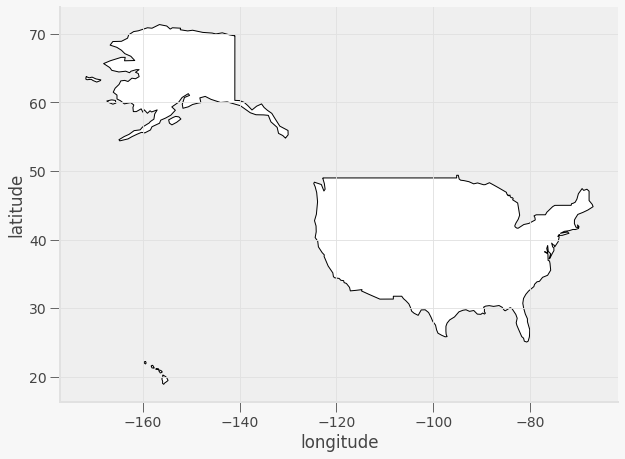

In [63]:
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world.query("name == 'United States of America'").plot(ax=gax, edgecolor='black',color='white')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

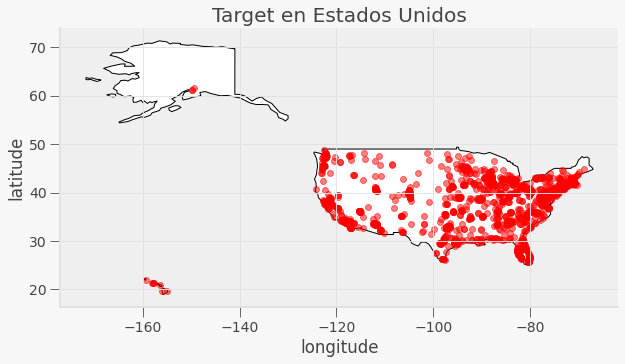

In [64]:
# Step 3: Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

¿qué tal ahora?, tiene mayor sentido verdad, entonces los datos lejanos no eran atípicos, de aquí la importancia de ver los datos con el tipo de gráfica correcta.

Ahora sí, implementa K means a los datos de latitud y longitud :) y encuentra donde colocar los almacenes. 

Nota: si te llama la atención implementar alguna otra visualización con otra librería, lo puedes hacer, no hay restricciones.

In [65]:
#tu codigo aquí

# Número ideal de almacenes

In [75]:
# Importamos K medias
from sklearn.cluster import KMeans

# Para visualización de los datos
import seaborn as sns

# Para geocodificación inversa (obtención de direcciones a partir de coordenadas)
import geopy

Encuentra el numero ideal de almacenes, justifica tu respuesta:

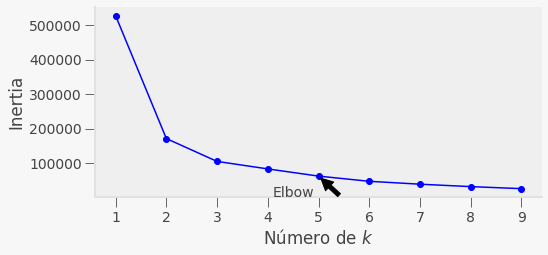

In [187]:
# Entrenamos 10 modelos distintos variando el valor de k de 1 a 9
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(latlong)
                for k in range(1, 10)]

# Medimos el valor de la inercia de cada modelo
inertias = [model.inertia_ for model in kmeans_per_k]

# Imprimimos gráfica de codo
## Establecemos el tamaño del canvas
plt.figure(figsize=(8, 3.5))
## Imprimimos el valor de las inercias resultantes en el eje Y (como curva de línea)
plt.plot(range(1, 10), inertias, "bo-")

plt.xlabel("Número de $k$")
plt.ylabel("Inertia")
plt.annotate("", xy=(5, inertias[4]), xytext=(5.45, 650),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.text(4.5, 650, "Elbow", horizontalalignment="center")
#plt.axis([1, 8.5, 0, 1300])
plt.grid()
#save_fig("inertia_vs_k_plot")
plt.show()

In [68]:
df_inertias = pd.DataFrame(inertias,columns = ['inertia'])
df_inertias['intertia_pct_change'] = df_inertias['inertia'].pct_change()*100
df_inertias['pct_change_of_change'] = df_inertias['intertia_pct_change'].pct_change()*100
df_inertias

,inertia,intertia_pct_change,pct_change_of_change
0,527995.443069,NaN,NaN
1,171146.625996,-67.585587,NaN
2,104757.409018,-38.790842,-42.604860
3,82987.937724,-20.780842,-46.428485
4,62084.096314,-25.189012,21.212664
5,47006.097446,-24.286411,-3.583311
6,38595.197685,-17.893210,-26.324190
7,31577.113579,-18.183827,1.624176
8,25656.624333,-18.749305,3.109782


Ya que K medias es un método de apendizaje no supervisado, no existe una forma de directa de determinar el desempeño del modelo. Sin embargo, es posinle medir la inercia del modelo, es decir, la suma de las distancias entre cada punto y su centroide asignado por el modelo. Al realizar pruebas con cada número de centroides distintos se puede medir dicha  sumatoria de distancias para cada caso y comparar el efecto del incremento de este valor. Si bien al aumentar el número de puntos se tiende areducir la inercia, se busca elegir un número más pequeño el cual muestre el último cambio abrupto en la medición de dicha inercia. Esta observación se simplifica mediante la visualización llamada "gráfica de codo" la cuál muestra la progresión descendente de la inercia al aumentar el valor de k. Podemos observar que el valor ideal puede estar entre 3 y 5, al observarse cambios porcentuales semejantes hasta ese punto. La decisión idealmente debería ser complementada con el análisis geográfico del mismo. En este caso se elige el valor 5 ya que además de brinda buenos resultados geográficamente, es aquella anterior al crecimiento repentino del procentaje de cambio con respecto al cambio anterior; esto indica que si bien los cambios siguientes pueden tener magnitudes procentuales más elevadas esto tiende a ser por la ligera disminución en la magnitud real de las inercias.

# Mejor modelo

In [82]:
# Asignamos el valor ideal de k
k = 5

# Construimos el modelo
kmeans_ideal = KMeans(n_clusters=k, random_state=42)

# Entrenamos el modelo ideal
kmeans_ideal.fit(latlong)

# Obtenemos los centroides
centroides = kmeans_ideal.cluster_centers_
centroides

array([[  40.34365502,  -75.58507975],
       [  37.57977424, -119.17634307],
       [  41.7596358 ,  -88.35497835],
       [  31.10391163,  -82.93309211],
       [  34.42035677,  -98.26633716]])

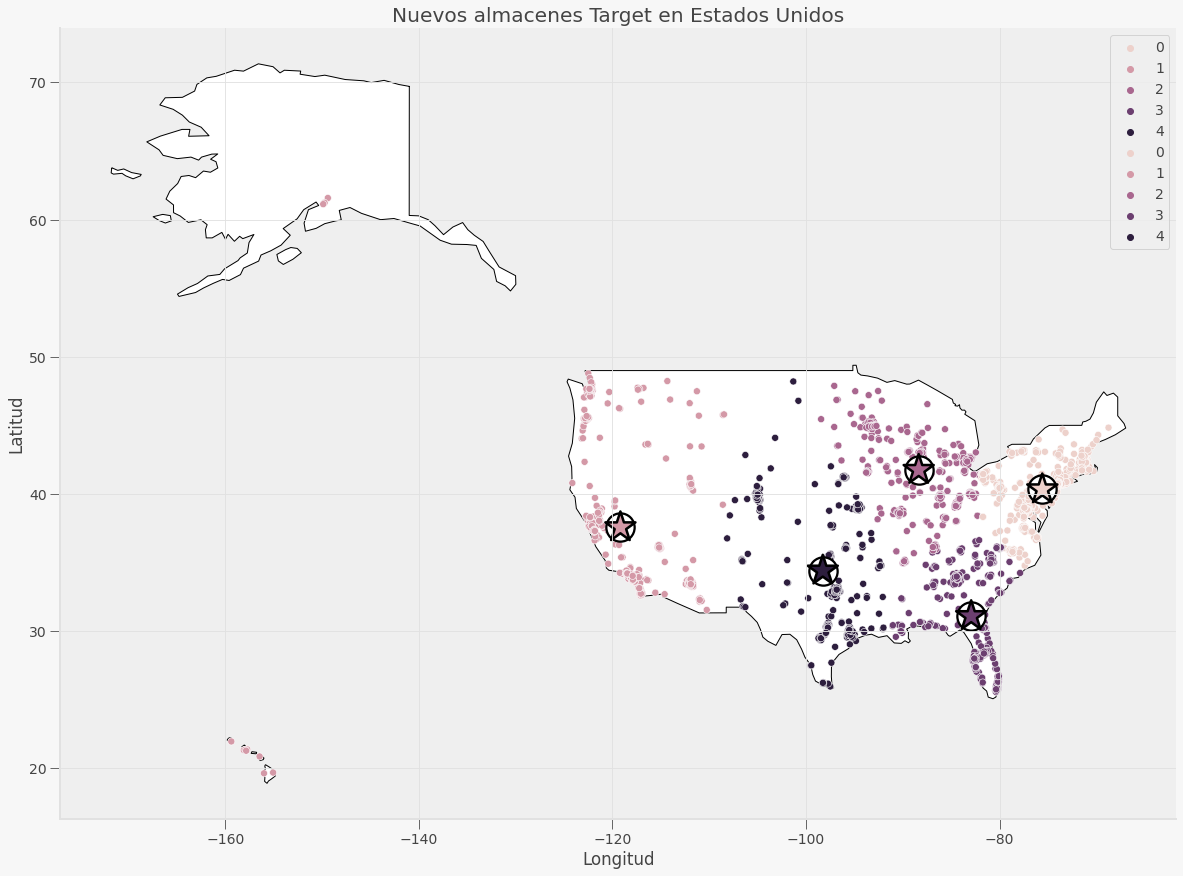

In [110]:
# Impresión de ubicación de nuevas tiendas

## Tamaño del mapa
fig, gax = plt.subplots(figsize=(20,20))

# Impresión de países en los que se encuentran los puntos
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# Impresión de los puntos originales
sns.scatterplot(x = latlong['longitude'], y = latlong['latitude'], hue=kmeans_ideal.labels_, s = 50)

#Impresión de los puntos de los nuevos almacenes
sns.scatterplot(x = centroides[:,1], y = centroides[:,0], s=800, marker = 'o', color = 'white', edgecolor = 'black')
sns.scatterplot(x = centroides[:,1], y = centroides[:,0], hue=np.unique(kmeans_ideal.labels_), s=1000, marker = '*', edgecolor = 'black')

# Establecemos nombre de los ejes y el título del gráfico
gax.set_xlabel('Longitud')
gax.set_ylabel('Latitud')
gax.set_title('Nuevos almacenes Target en Estados Unidos')


# Borramos las líneas de medición de la parte superior y derecha del mapa
gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)




plt.show()

# Preguntas

## Encuentra las latitudes y longitudes de los almacenes, ¿qué ciudad es?

In [171]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="GetLoc")

def ciudad_geocode(row):
    coord = f"{row['latitud_c']}, {row['longitud_c']}"
    location = geolocator.reverse(coord)
    address = location.address
    return address

In [172]:
#Latitudes y longitudes de los almacenes
df_centroides = pd.DataFrame(centroides, columns = ['latitud_c','longitud_c'])
df_centroides

,latitud_c,longitud_c
0,40.343655,-75.585080
1,37.579774,-119.176343
2,41.759636,-88.354978
3,31.103912,-82.933092
4,34.420357,-98.266337


In [173]:
# Mostramos la dirección relativa a las coordenadas de los nuevos almacenes

## Expandemos ancho de columnas para ver drección completa
pd.set_option('max_colwidth',None)

##  Aplicamos geocodificación invertida para obtener dirección de las coordenadas GPS
df_centroides['ciudad'] = df_centroides.apply(ciudad_geocode, axis = 1)
df_centroides

,latitud_c,longitud_c,ciudad
0,40.343655,-75.585080,"Congo Road, Congo, Douglass Township, Montgomery County, Pennsylvania, 19525, United States"
1,37.579774,-119.176343,"Iron Lake Trail, Madera County, California, United States"
2,41.759636,-88.354978,"129, South Western Avenue, Aurora, Aurora Township, Kane County, Illinois, 60506, United States"
3,31.103912,-82.933092,"Foyd Lee Loop, Clinch County, Georgia, United States"
4,34.420357,-98.266337,"County Road E1790, Cotton County, Oklahoma, United States"


## ¿a cuantas tiendas va surtir?

In [137]:
# Concatenamos el resulado de Kmeans a la tabla original, aprovechamos que Kmeans mantiene el orden de los datso originales
df['cluster'] = kmeans_ideal.labels_

# Con un value counts, contamos cuantos valores s crearon por cada k, estas son la cantidad de tiendas que corresponden  a cada nuevo almacen
df['cluster'].value_counts()

0    480
2    422
1    368
4    296
3    273
Name: cluster, dtype: int64

## ¿sabes a que distancia estará?

In [174]:
# Agregamos una columna de cluster parta su fácil identificación
df_centroides['cluster'] = df_centroides.index
df_centroides

,latitud_c,longitud_c,ciudad,cluster
0,40.343655,-75.585080,"Congo Road, Congo, Douglass Township, Montgomery County, Pennsylvania, 19525, United States",0
1,37.579774,-119.176343,"Iron Lake Trail, Madera County, California, United States",1
2,41.759636,-88.354978,"129, South Western Avenue, Aurora, Aurora Township, Kane County, Illinois, 60506, United States",2
3,31.103912,-82.933092,"Foyd Lee Loop, Clinch County, Georgia, United States",3
4,34.420357,-98.266337,"County Road E1790, Cotton County, Oklahoma, United States",4


In [180]:
# Combinamos los 2 DataFrames (original y de centroides) para obtener la distancia de cada tienda con su nuevo almacén
df_dist = df.merge(df_centroides[['cluster','latitud_c','longitud_c']], how = 'left', on = ['cluster'])
df_dist

,name,latitude,longitude,address,phone,website,Coordinates,cluster,latitud_c,longitud_c
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423),3,31.103912,-82.933092
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455),3,31.103912,-82.933092
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287),3,31.103912,-82.933092
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-6531",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015),3,31.103912,-82.933092
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.44642 31.26606),3,31.103912,-82.933092
...,...,...,...,...,...,...,...,...,...,...
1834,Waukesha,43.034293,-88.176840,"2401 Kossow Rd, Waukesha, WI 53186-2904",262-784-8646,https://www.target.com/sl/waukesha/82,POINT (-88.17684 43.03429),2,41.759636,-88.354978
1835,Waukesha South,42.989604,-88.259806,"1250 W Sunset Dr, Waukesha, WI 53189-8423",262-832-1272,https://www.target.com/sl/waukesha/2546,POINT (-88.25981 42.98960),2,41.759636,-88.354978
1836,Casper,42.846799,-106.264166,"401 SE Wyoming Blvd, Casper, WY 82609-4219",307-265-8214,https://www.target.com/sl/casper/164,POINT (-106.26417 42.84680),4,34.420357,-98.266337
1837,Cheyenne,41.162019,-104.800048,"1708 Dell Range Blvd, Cheyenne, WY 82009-4945",307-637-8888,https://www.target.com/sl/cheyenne/224,POINT (-104.80005 41.16202),4,34.420357,-98.266337


In [182]:
# Para medir la distancia entre dos puntos una medida correcta es la distancia geodésica
from geopy.distance import geodesic



In [186]:
# Applicamos la función de distancia egodésica con una función lambda sobre las coordenadas de la tienda con respecto a su propio almacén asignado
df_dist['distancia [km]'] = df_dist[['longitude','latitude','longitud_c','latitud_c']].apply(lambda x: geodesic((x['latitude'],x['longitude']),(x['latitud_c'],x['longitud_c'])).km, axis = 1)
df_dist['distancia [km]']

0        434.234792
1        455.376977
2        477.893070
3        538.313337
4        240.237435
           ...     
1834     142.347758
1835     136.850171
1836    1164.937003
1837     943.347142
1838     964.894858
Name: distancia [km], Length: 1839, dtype: float64

Se debe considerar que la distancia general de todas las ubicaciones con respecto a cada almacén asignado se obtiene mediante las inercias, sin embargo, al ser este parámetro una sumatorio no brinda información útil.

In [252]:
# Estadística descriptiva de distancia de los alamcenes a sus respectivas tiendas (en km)
df_dist.groupby(['cluster'])['distancia [km]'].agg(['mean','max','min'])

,mean,max,min
cluster,,,
0,275.207009,751.252736,10.266436
1,677.007456,4214.559777,95.581037
2,350.750655,968.251771,4.349837
3,425.711256,782.167947,46.624021
4,550.081583,1551.822992,31.343672


## ¿qué librerías nos pueden ayudar a graficar este tipo de datos?

Adicionalmente, en el notebook notaras que al inicio exploramos los datos y los graficamos de manera simple, después nos auxiliamos de una librería de datos geográficos.

¿qué librerías nos pueden ayudar a graficar este tipo de datos?
¿Consideras importante que se grafique en un mapa?, ¿por qué?
Agrega las conclusiones

Después de la investigación relizada aqupí se presenta un conjunto de librerías que pueden ser de mucha utilidad para la visualización de datos geográficos:

* Geopandas
* ipyleaflet
* folium
* Seaborn

### ipyleaflet

Esta librería es la primer y m´sas simple librería que permite visualizar de manera dinámica características de entoenro al centrado en un a ubicación específica.

In [188]:
! pip install ipyleaflet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.7 MB 22.0 MB/s 
     |████████████████████████████████| 55 kB 4.3 MB/s 
     |████████████████████████████████| 1.6 MB 32.5 MB/s 


In [190]:
from ipyleaflet import *

In [200]:
# Visualización interactiva de zona del almacén Almacén 1
center = [df_centroides.loc[0,'latitud_c'], df_centroides.loc[0,'longitud_c']]
zoom = 10
m = Map(center = center, zoom = zoom)
m


Map(center=[40.34365501878914, -75.58507975156577], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [199]:
# Con esta función podemos modificar el zoom de la misma
m.interact(zoom = (5,10,1))

Box(children=(IntSlider(value=10, description='zoom', max=10, min=5),))

### Folium

Esta librería permite, mediante la adición de capas la adición de informació complmentaia a un mapa interactivo generado a partir de Python y coordenadas.

In [234]:
! pip install folium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [239]:
## Ubicación del segúndo almacén

a2 = [df_centroides.loc[1,'latitud_c'], df_centroides.loc[1,'longitud_c']]

In [240]:
import folium

m_f = folium.Map(location = a2)

In [241]:
m_f

In [242]:
# Creación de html del mapa mostrado
m_f.save("index.html")

In [244]:
# Visión topográfica

m_f_i = folium.Map(location=a2, zoom_start=12, tiles="Stamen Terrain")

tooltip = "Click me!"

folium.Marker(
    a2, popup="<i>Mt. Hood Meadows</i>", tooltip=tooltip
).add_to(m_f_i)
folium.Marker(
    a2, popup="<b>Timberline Lodge</b>", tooltip=tooltip
).add_to(m_f_i)

m_f_i

In [245]:
# Creación de círculos de impacto (asignados arbitrartiamente en este caso)

m = folium.Map(location=a2, tiles="Stamen Toner", zoom_start=13)

folium.Circle(
    radius=100,
    location=a2,
    popup="The Waterfront",
    color="crimson",
    fill=False,
).add_to(m)

folium.CircleMarker(
    location=a2,
    radius=50,
    popup="Laurelhurst Park",
    color="#3186cc",
    fill=True,
    fill_color="#3186cc",
).add_to(m)


m

### Seaborn

Retomando del ejerciio construido por mi parte, y después de hacer una exhaustiva investigación, he descubierto que seaborn es un excelente elemento que permite rápidamente mostrar sus gráficos fácilmente contruidos sobre el canvas de elementos geográficos, de esta manera, como se ejemplifica, se pueden crear figuras y colorearlos de manera muy visual para fácilmente y de manera flexible visualizar ubicación de elementos especiales sobre un mapa predefinido con ayuda de geopandas.

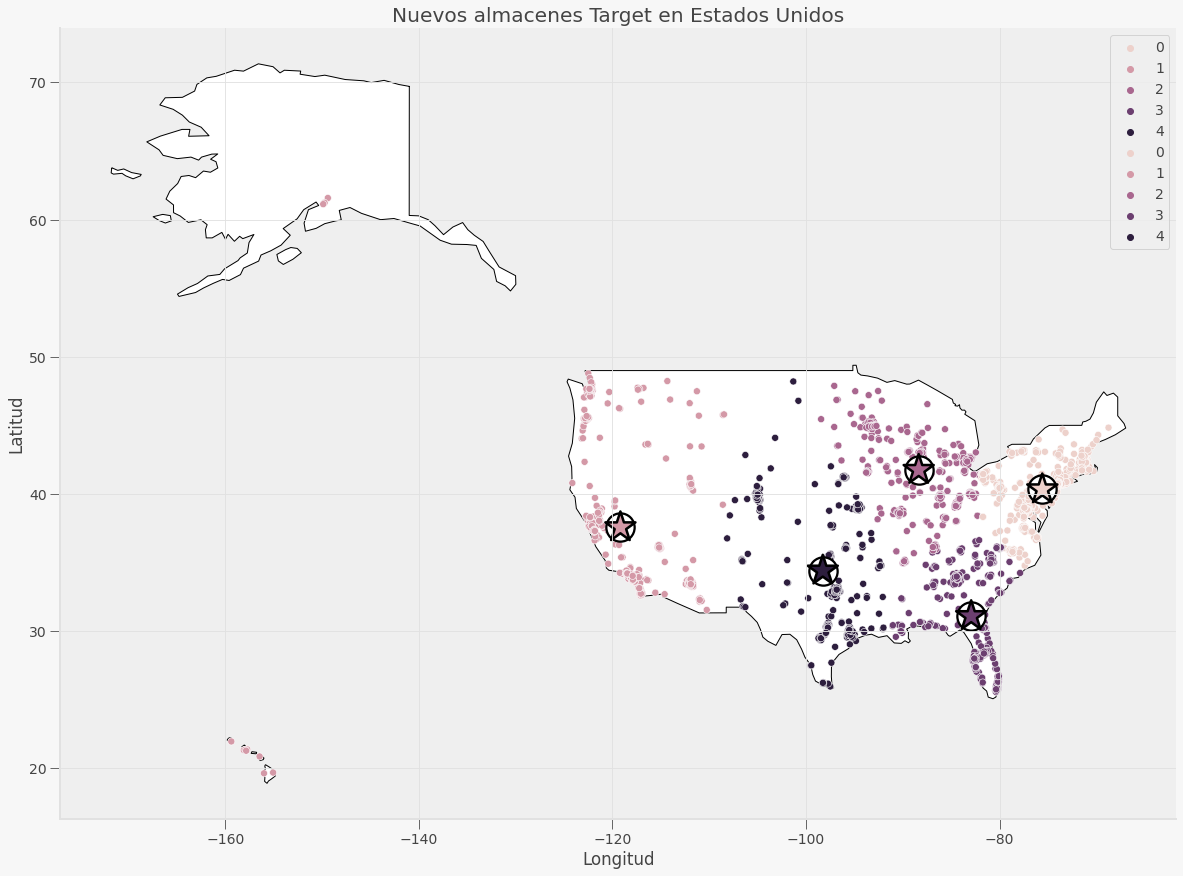

In [246]:
# Impresión de ubicación de nuevas tiendas

## Tamaño del mapa
fig, gax = plt.subplots(figsize=(20,20))

# Impresión de países en los que se encuentran los puntos
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# Impresión de los puntos originales
sns.scatterplot(x = latlong['longitude'], y = latlong['latitude'], hue=kmeans_ideal.labels_, s = 50)

#Impresión de los puntos de los nuevos almacenes
sns.scatterplot(x = centroides[:,1], y = centroides[:,0], s=800, marker = 'o', color = 'white', edgecolor = 'black')
sns.scatterplot(x = centroides[:,1], y = centroides[:,0], hue=np.unique(kmeans_ideal.labels_), s=1000, marker = '*', edgecolor = 'black')

# Establecemos nombre de los ejes y el título del gráfico
gax.set_xlabel('Longitud')
gax.set_ylabel('Latitud')
gax.set_title('Nuevos almacenes Target en Estados Unidos')


# Borramos las líneas de medición de la parte superior y derecha del mapa
gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)




plt.show()

¿Consideras importante que se grafique en un mapa?, ¿por qué? Agrega las conclusiones

Considero que realmente sí es importante la visualizaión de la información geográfica en un mapa ya que, de lo conterio no se permite distinguir tendencias y patrones que en simples gráficos de dispersión no sería detectados, tales como la limitaciones posicionales (por ejemplo, que una ubicación quedara en el mar), distribución física (densidad real de los datos) e incluso características demográficas. 
Adicionalmente, el uso de herramientas avanzadas de visualización permite considerar de manera rápida, dinámica y precisa factores imposibles de percibir con gráficos comunes; factores topográficos y elementos de urbanización, los cuales son esenciales en la toma de decisones de negocio como las analizadas en este caso.



# Concluciones

En conclusión, con base en lo analizado a lo largo de la presente práctica, se llegan a los siguientes puntos:
El uso de técnicas de aprendizaje no supervisado, como lo es K medias, permite no solo la asignación de clases a datos no etiquetados sino que a su vez, permite la solución de problemas relacionados con determinación de centroides para aplicaciones práticas.
Adicionalmente, se pudo observar que el uso de herramientas especializadas como el objeto POINT, permiten simplificar el procesamiento de información geo codificada para su análisis, reduciendo la cantidad de operaciones de manipulación de datos para obtención de información necesitada.
Por otra parte, el uso de técnicas de aprendizaje no supervisado si bien son constituidos a partir de un conjunto de datos no etiquetados es posible analizar cuál sería su mejor desempeño a partir de la comparación de modelos con diferente parámetro (una aproximación muy semejante a la utilizada en el aprendizaje supervisado en técnicas como GridSearch), sin embargo, la elección de estos requiere una elevada generación de modelos para su comparación, con lo cual se concluye que, para grandes volúmenes de datos, es probable que este tipo de análisis requieran un muy elevado costo de procesamiento.
Por último, se observó que el uso de librerías especializadas en el despliegue de información geográfica visual permitía el desarrollo de análisis más complejos y completos que permitían observar mayor cantidad de condiciones de los lugares asignados para la ubicación de nuevos almacenes. Esto permitió la consideración de nuevos factores que serían de vital consideración a la hora de la aprobación de las ubicaciones determinadas, con lo cual se llega a la conclusión que el uso de material de visualización geográfico es esencial como parte del proceso de analítica de datos que involucran de manera central componentes geográficos.
